In [1]:
using PyPlot

In [26]:
# discretization
t = Array(2020:1.:2100);

# CO2 concentration (ppm) at t[1]
c_00 = 415.;

# physical climate parameters
ECS = 3.; # Equilibrium Climate Sensitivity
ϵ = ECS/log(2.); # Transient Warming Parameter
δT_00 = 1.1; # Warming at t[1] since preindustrial

# baseline emissions scenarios
q = 5. .* ones(size(t)); # emissions scenario
q[40:81] .= q[1] * (40. .-(0.:1.:41.))/40.
q[81:end] .= 0.
c_0 = c_00 .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT_00 .+ ϵ.*log.(c_0/c_00); # warming due to baseline emissions scenario

# economic parameters
β = 1.; # damage parameter (trillion dolars / C^2)
D_0 = β .* δT_0.^2; # baseline damages
γ = 0. #1. /30. # discount rate
ρ = 0.03
GWP = 100. # Global World Product (10^12 $/yr)
C_ϕ = 0.05*GWP; # carbon removal (10^12 $/yr)
C_φ = 0.05*GWP; # emissions reductions (10^12 $/yr)
C_χ = 0.1*GWP; # adaptation (10^12 $/yr)
C_λ = 0.2*GWP; # geoengineering (10^12 $/yr)

f_low(α::Array) = (α ./ (1. .+ α)).^2 # shape of individual cost functions
f_med(α::Array) = α.^2 # shape of individual cost functions
f_high(α::Array) = (α ./ (1. .- 0.9α)).^2 # shape of individual cost functions

# Example control trajectories
# (picked because cost of controls + cost of controlled damage < uncontrolled damage)
nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);
ϕ = nondim_linear(t);
φ = nondim_linear(t)/3.;
λ = nondim_linear(t)/10.;
χ = nondim_linear(t)/10.;

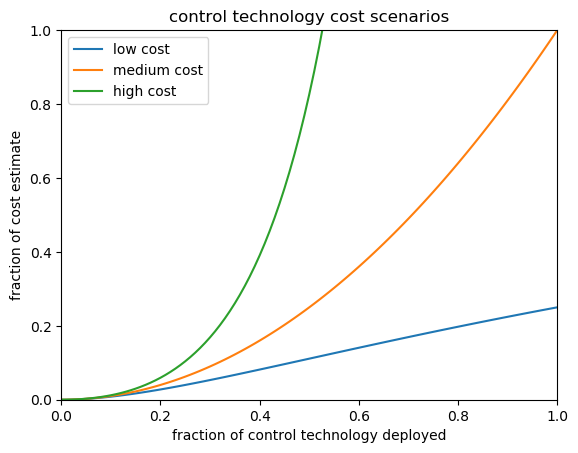

PyObject <matplotlib.legend.Legend object at 0x144aecac8>

In [27]:
x = 0:0.01:1.

y_low = (x./(1. .+x)).^2
y_med = x.^2
y_high = (x./(1. .-0.9x)).^2
title("control technology cost scenarios")
plot(x,y_low, label="low cost")
plot(x,y_med, label="medium cost")
plot(x,y_high, label="high cost")
xlim([0,1])
ylim([0,1])
ylabel("fraction of cost estimate")
xlabel("fraction of control technology deployed")
legend()

In [28]:
c(ϕ::Array, φ::Array) = c_0 .- cumsum(q .* φ) .- cumsum(q[1] .* ϕ);
δT(ϕ::Array, φ::Array) = δT_00 .+ ϵ.*log.(c(ϕ,φ)./c_00);

D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1. .- χ) .* β .* δT(ϕ, φ).^2 .* (1. .- λ).^2;

C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_high(λ) .+ C_ϕ.*f_high(ϕ) .+ C_φ.*f_high(φ) .+ C_χ.*f_high(χ);
T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
    sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* (1. / (1. + ρ)).^(t.-t[1])) .+
    200. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
    200. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
);

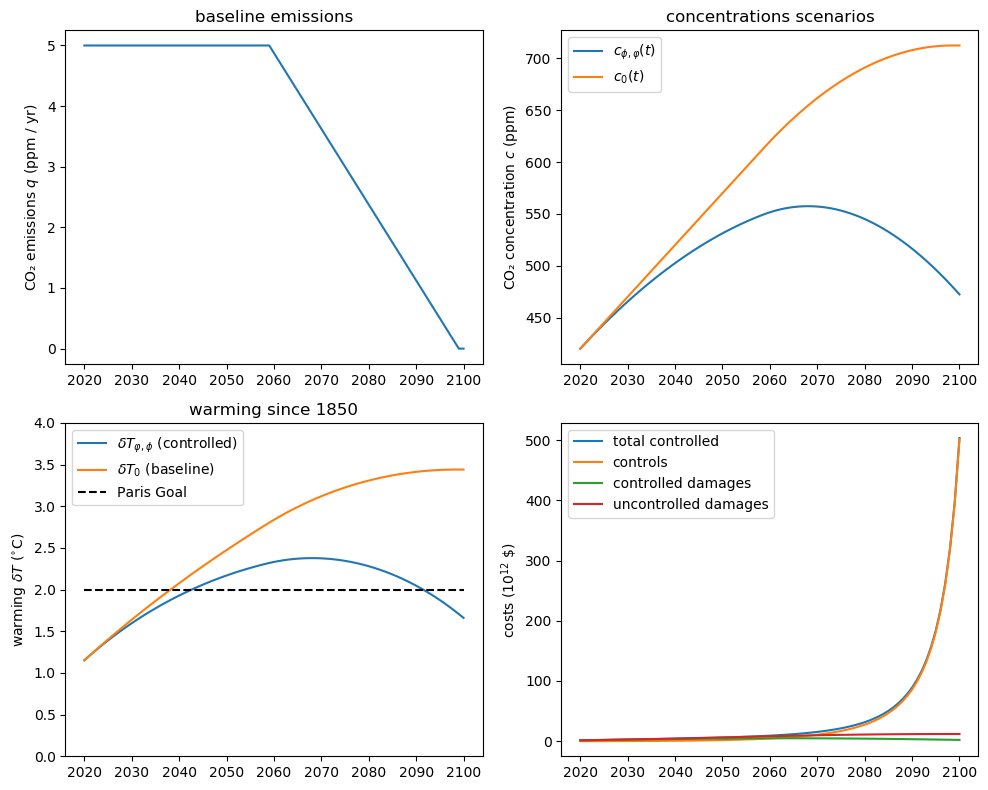

In [29]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total controlled")
plot(t, C(ϕ, φ, χ, λ), label="controls")
plot(t, D(ϕ, φ, χ, λ), label="controlled damages")
plot(t, D_0, label="uncontrolled damages")
ylabel(L"costs (10$^{12}$ \$)")
legend()
tight_layout()

## Gradient descent cost minimization

In [30]:
function ∇T(ϕ::Array, φ::Array, χ::Array, λ::Array)
    Δα = 1.e-5
    ∂T∂ϕ = zeros(size(ϕ))
    ∂T∂φ = zeros(size(φ))
    ∂T∂χ = zeros(size(χ))
    ∂T∂λ = zeros(size(λ))
    for i=1:length(ϕ)
        δα = zeros(size(ϕ))
        δα[i] = Δα
        ∂T∂ϕ[i] = (T(ϕ.+δα,φ,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂φ[i] = (T(ϕ,φ.+δα,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂χ[i] = (T(ϕ,φ,χ.+δα,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂λ[i] = (T(ϕ,φ,χ,λ.+δα) .- T(ϕ,φ,χ,λ))/Δα
    end
    
    return (∂T∂ϕ, ∂T∂φ, ∂T∂χ, ∂T∂λ)
end

function convergence(∇T, tol = 1.e-6)
    norm = 0.
    for ∂T∂α = ∇T
        norm += sum(∂T∂α.^2)
    end
    return norm < tol
end

convergence (generic function with 2 methods)

In [31]:
count = 1
while convergence(∇T(ϕ, φ, χ, λ), 1.e-8) == false
    ∇ = ∇T(ϕ, φ, χ, λ)
    norm = 0.
    for ∂T∂α = ∇
        norm += sum(∂T∂α.^2)
    end
    print(norm, " ")
    Δs = 5.e-4
    ϕ .-= ∇[1].*Δs
    φ .-= ∇[2].*Δs
    χ .-= ∇[3].*Δs
    λ .-= ∇[4].*Δs
    count+=1
    
    if count>1000
        break
    end
end

2.194804381670793e6 48508.813367833674 30803.821665125783 22422.67715936294 17489.753267012733 14241.47691461664 11947.330153646417 10246.186419331636 8938.170027429776 7903.569255035515 7066.355548209695 6375.992520280747 5797.63524793524 5306.520638673819 4884.5962774287345 4518.4113139964265 4197.751583543819 3914.730326235453 3663.1671262658383 3438.154230880727 3235.747778923054 3052.744128719771 2886.515218180979 2734.885731965357 2596.0401482532666 2468.4517297138113 2350.8274979025196 2242.065327750664 2141.220044496579 2047.4765199122933 1960.1280585805382 1878.5589424282928 1802.2302706871292 1730.6682982703412 1663.4548574444896 1600.219450784887 1540.6325877805173 1484.4002695227407 1431.2592982962608 1380.973336176377 1333.329548314794 1288.1357268198042 1245.2178483461628 1204.417944154812 1165.5922974360399 1128.6098448210535 1093.3508105822907 1059.7055118586245 1027.573309226386 996.8616763018038 967.4854120191866 939.3659094496118 912.4305320673027 886.6120513250578 8

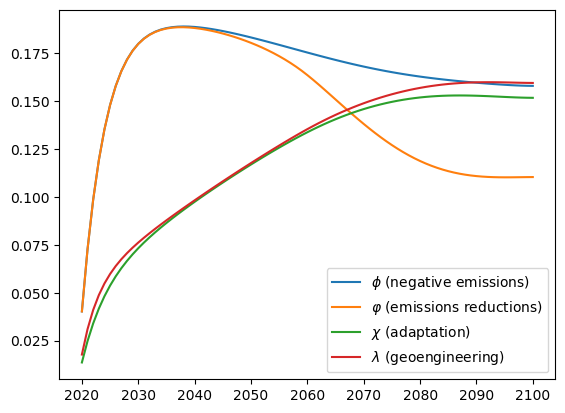

PyObject <matplotlib.legend.Legend object at 0x143352978>

In [34]:
plot(t, ϕ, label=L"$\phi$ (negative emissions)")
plot(t, φ, label=L"$\varphi$ (emissions reductions)")
plot(t, χ, label=L"$\chi$ (adaptation)")
plot(t, λ, label=L"$\lambda$ (geoengineering)")
legend()

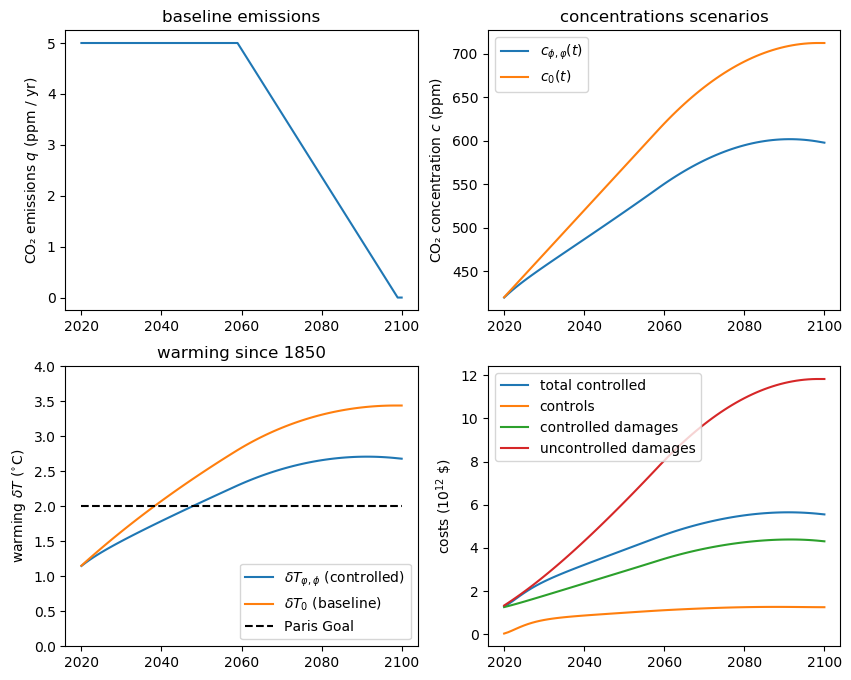

PyObject <matplotlib.legend.Legend object at 0x147664f60>

In [35]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total controlled")
plot(t, C(ϕ, φ, χ, λ), label="controls")
plot(t, D(ϕ, φ, χ, λ), label="controlled damages")
plot(t, D_0, label="uncontrolled damages")
ylabel(L"costs (10$^{12}$ \$)")
legend()